## Score history

데이터 로드 

In [ ]:
!unzip /content/drive/MyDrive/DataSet/전해탈지/Dataset.zip

라이브러리 모듈 

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from glob import glob 
from tqdm import tqdm

from sklearn.ensemble import IsolationForest

# CSV 데이터 병합 

## csv 리스트 디렉토리 

In [ ]:
csv_list_dir = glob('/content/data/*.csv')
csv_list_dir.sort()
csv_list_dir.remove( '/content/data/Error Lot list.csv',)

## input 데이터 로드 

In [ ]:
def add_date(df,dir):
  date = dir[-14:-4]
  df['date'] = date
  return df 
  
#init 
dir = csv_list_dir[0]
df = pd.read_csv(dir)
df = add_date(df,dir)

for dir in csv_list_dir[1:]:
  temp_df = pd.read_csv(dir)
  temp_df = add_date(temp_df,dir)
  df = pd.concat([df,temp_df],axis=0)

## output 데이터 로드

In [ ]:
error = pd.read_csv('/content/data/Error Lot list.csv')
error = error.fillna(0)
error['Date'] = error['Date'].apply(lambda x : x.replace('-','.')) # input 데이터랑 date 형태 통일 

## error 데이터 parsing 

In [ ]:
df['error']=0

def add_error(df,error,index):
  date = error.iloc[index,:]['Date']
  LoT = error.iloc[index,:]['LoT']
  LoT2 = error.iloc[index,:]['LoT2']
  df.loc[(df['date']==date)&(df['Lot']==LoT),'error']=1
  df.loc[(df['date']==date)&(df['Lot']==LoT2),'error']=1
  return df
  
for index in range(len(error)):
  df = add_error(df,error,index)

15.0
15


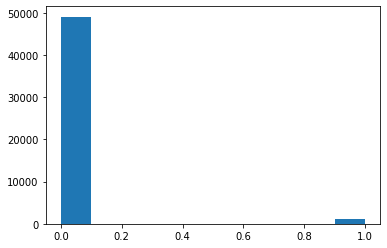

In [ ]:
#정상적으로 입력 됬는지 확인 
print(len(df[df['error']==1])/69)
temp = np.array(error)[:,2:]
print(len(temp[temp!=0]))
plt.hist(df['error'])
plt.show()

In [ ]:
np.array(df).shape

(50094, 8)

# 전처리

## 편차 게산 

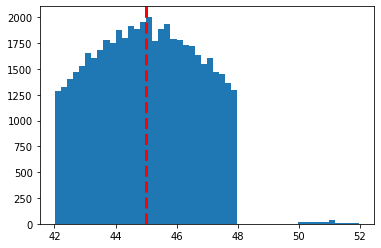

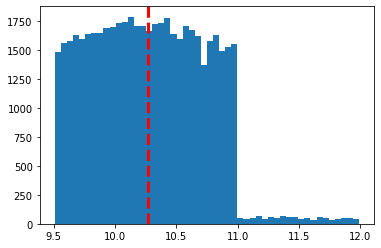

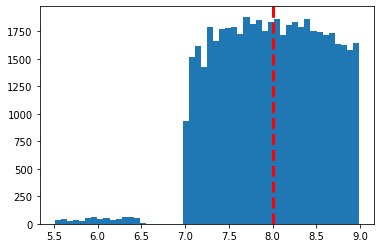

In [ ]:
plt.hist(df['Temp'],bins=50)
plt.axvline(45,color = 'r', linestyle = '--', linewidth=3)
plt.show()

plt.hist(df['pH'],bins=50)
plt.axvline(10.27,color = 'r', linestyle = '--', linewidth=3)
plt.show()

plt.hist(df['Current'],bins=50)
plt.axvline(8,color = 'r', linestyle = '--', linewidth=3)
plt.show()

편차 계산을 위한 각 변수들 평균 계산 

In [ ]:
columns = ['pH','Temp','Current']
mean_values = np.mean(df[columns],axis=0)
print('Ph = ' ,mean_values[0])
print('Temp = ', mean_values[1])
print('Current = ', mean_values[2])

Ph =  10.273345909689734
Temp =  45.02384696770085
Current =  7.974549247414772


In [ ]:
####

,Index,Lot,Time,pH,Temp,Current,date,error,Current_diff,Temp_diff,pH_diff
0,1,1,오후 4:29:15.0,10.37,42.87,7.34,2021.09.06,0,0.56,2.13,0.10
1,2,1,오후 4:29:20.0,10.90,42.70,8.26,2021.09.06,0,0.36,2.30,0.63
2,3,1,오후 4:29:25.0,9.61,42.37,8.46,2021.09.06,0,0.56,2.63,0.66
3,4,1,오후 4:29:30.0,10.32,45.85,8.04,2021.09.06,0,0.14,0.85,0.05
4,5,1,오후 4:29:35.0,10.36,44.18,7.23,2021.09.06,0,0.67,0.82,0.09


### EDA 

비정상의 편차 분포 

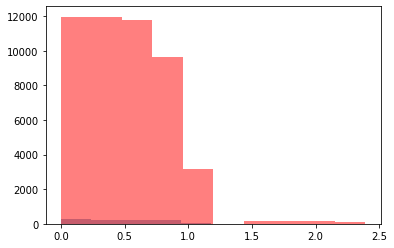

In [ ]:
plt.hist(df[df['error']==1]['Current_diff'],alpha=0.5)
plt.hist(df[df['error']==0]['Current_diff'],color='r',alpha=0.5)
plt.show()

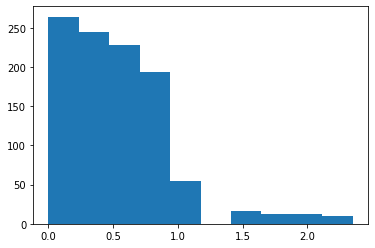

In [ ]:
plt.hist(df[df['error']==1]['Current_diff'])
plt.show()

In [ ]:
len(df.loc[(df['error']==1) & (df['Current_diff']>1)])/len(df.loc[df['error']==1])

0.08115942028985507

In [ ]:
len(df.loc[(df['error']==0) & (df['Current_diff']>1)])/len(df.loc[df['error']==0])

0.05430196294257934

In [ ]:
len(df.loc[(df['error']==0) & (df['pH_diff']>1)])/len(df.loc[df['error']==0])

0.013208585580627407

In [ ]:
len(df.loc[(df['error']==1) & (df['pH_diff']>1)])/len(df.loc[df['error']==1])

0.04830917874396135

## 컬럼제거

In [ ]:
# cols = ['pH','Temp','Current','Current_diff','Temp_diff','pH_diff','Timestamp','error']
cols = ['pH','Temp','Current','Current_diff','Temp_diff','pH_diff','error']
# cols = ['pH','Temp','Current','error']
# input = np.array(df[cols])
input = df[cols]

## scaling 

In [ ]:
max = np.max(input.iloc[:,:-1],axis=0)
min = np.min(input.iloc[:,:-1],axis=0)

In [ ]:
for col in input.columns[:-1]:
  input[col] = input[col].apply(lambda x : (x-min[col])/(max[col]-min[col]))
input = np.array(input)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 시계열 분할 

In [ ]:
input = input.reshape(-1,69,7)
input.shape

(726, 69, 7)

output 제작

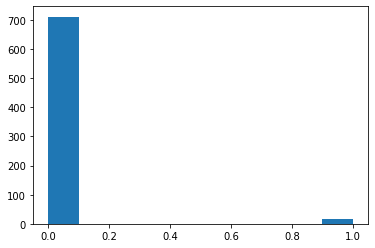

In [ ]:
output = np.zeros(726)
for index in range(726):
  temp = input[index]
  if temp[:,6].sum()==69:
    output[index]=1

plt.hist(output)
plt.show()

-

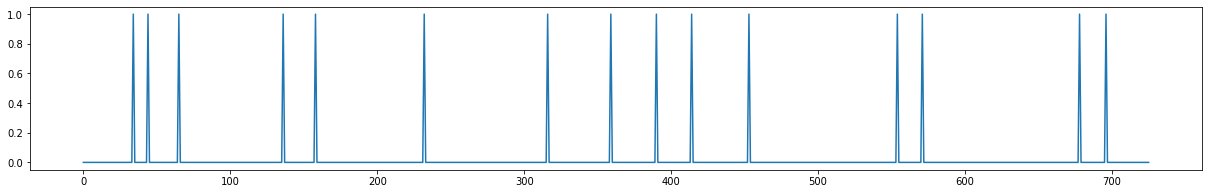

In [ ]:
plt.figure(figsize = (21,3))
plt.plot(np.arange(len(output)),output)
plt.show()

435.59999999999997

train : 400, test rest 

## Train - test - valid 분할 

In [ ]:
input = input[:,:,:-1].reshape(-1,69*6)
input.shape

train_x = input[:400,]
train_y = output[:400,]

valid_x = input[400:600,]
valid_y = output[400:600,]

test_x = input[600:,]
test_y = output[600:,]

In [ ]:
print(train_x.shape,valid_x.shape)

(400, 414) (200, 414)


#모델

In [ ]:
def check_recall(predicted,valid_y,estimator,feat):
  result = np.where(valid_y==1)[0]
  result
  n = 0 
  target = []
  for i in predicted:
    if i in result:
      n+=1
      target.append(i)
    else:
      pass
  if n!=0 :
    recall = n/len(result) #정답 중 맞춘 비율 (예측 정답 / 정답 갯수)  
    precision = n/len(predicted) #예측 중 정답 비율 (예측 정답 / 예측 갯수)
      
    if f1score >=0.1:
      print('-------')
      print(f'predicted ={len(predicted)}')
      print(f'recall = {recall}')
      print(f'precision = {precision}')
      print(f'f1score = {f1score}')
      print(f'n_estimators = {estimator}')
      print(f'max_features = {feat}')
      print(target,n)
      print('-------')
  else:
    pass

## Isolation Forest

In [ ]:
# for i in [120]:
for estimator in [100,110,120,130,140,150,160,170,180,190,200]:
  for feat in np.arange(1,40,1):
    IF = IsolationForest(n_estimators=estimator,contamination = 'auto',max_features=feat)
    IF.fit(train_x)
    y_ = IF.predict(valid_x)
    predicted = np.where(y_==-1)[0]
    check_recall(predicted,valid_y,estimator,feat)

-------
predicted =2
recall = 0.5
precision = 1.0
f1score = 0.6666666666666666
n_estimators = 100
max_features = 29
[14, 53] 2
-------
-------
predicted =4
recall = 0.5
precision = 0.5
f1score = 0.5
n_estimators = 190
max_features = 2
[154, 171] 2
-------


In [ ]:
estimator = 190
feat = 2
for i in range(100):
  IF = IsolationForest(n_estimators=estimator,contamination = 'auto',max_features=feat)
  IF.fit(train_x)
  y_ = IF.predict(valid_x)
  predicted = np.where(y_==-1)[0]
  check_recall(predicted,valid_y,estimator,feat)

In [1]:
estimator = 100
feat = 29
for i in range(100):
  IF = IsolationForest(n_estimators=estimator,contamination = 'auto',max_features=feat)
  IF.fit(train_x)
  y_ = IF.predict(valid_x)
  predicted = np.where(y_==-1)[0]
  check_recall(predicted,valid_y,estimator,feat)

NameError: ignored

### 분포확인 

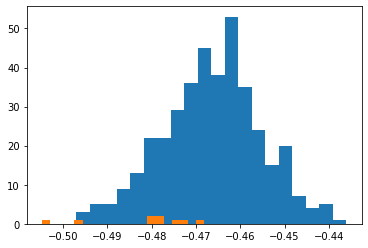

In [ ]:
# for i in [120]:
i =100
IF = IsolationForest(random_state=0,n_estimators=i,contamination = 0.5)
IF.fit(train_x)
train_score=  IF.score_samples(train_x)

plt.hist(train_score[np.where(train_y==0)[0]],bins=20)
plt.hist(train_score[np.where(train_y==1)[0]],bins=20)
plt.show()

In [ ]:
np.where(a<-0.494220210)

NameError: ignored

In [ ]:
np.where(test_y==1)

In [ ]:
  IF = IsolationForest(random_state=0,n_estimators=120,contamination = 'auto')
  IF.fit(train_x,train_y)
  y_ = IF.score_samples(test_x)

In [ ]:
y_[[53,296]]

In [ ]:
np.where(test_y==1)

In [ ]:
np.where(y_<-0.50)

## GB
- 주로 max_depth 와 n_estimator 
- lr은 0.001 단위까지 가면 너무 느려서 둘쨋 자리 까지 
- metrics = f1-score 

In [ ]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb

In [ ]:
for i in [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]:
  xgb = GradientBoostingClassifier(n_estimators= i, learning_rate = 0.01, max_depth = 5, random_state = 0)
  xgb.fit(train_x,train_y)
  y_ = xgb.predict_proba(test_x)
  predicted = np.where(y_==-1)[0]
  check_recall(predicted,result)

## LGBM

In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb

In [ ]:
d_train = lgb.Dataset(train_x, label=train_y)
params = {}
params['learning_rate'] = 0.06
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'bi'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 5
clf = lgb.train(params, d_train, 100)

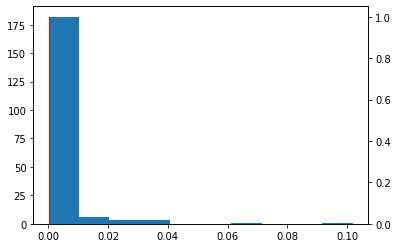

In [ ]:
y_ = clf.predict(valid_x)
target_index = np.where(valid_y==1)[0]
normal_index = np.where(valid_y==0)[0]
fig,ax1 = plt.subplots()

ax1.hist(y_[normal_index])

ax2 = ax1.twinx()
ax2.hist(y_[target_index],color='r')
plt.show()